In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob 
from scipy.io.wavfile import read
import IPython.display as ipd
import librosa
import librosa.display
import librosa.feature
import pickle
import sklearn
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Lambda,Input, concatenate, Conv2DTranspose, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.utils import np_utils
from keras.utils import to_categorical
from keras import optimizers 
from keras.models import load_model
from keras.models import model_from_json

import keras.backend as K 
# K.set_image_dim_ordering('tf')
print('Image ordering is tf check: ',K.image_dim_ordering())

Using TensorFlow backend.
/home/suhaila_shakia/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Image ordering is tf check:  tf


In [2]:
X = np.load('X_balanced.npy')
Y = np.load('Y_balanced.npy')

print('Shape of X: ',X.shape)
print('Shape of Y: ',Y.shape)

for lab in range(0,12):
    print('Number of samples in class: '+str(lab) +' = ',len(np.where(Y==lab)[0]))

Shape of X:  (169416, 128, 51, 1)
Shape of Y:  (169416, 1)
Number of samples in class: 0 =  14118
Number of samples in class: 1 =  14118
Number of samples in class: 2 =  14118
Number of samples in class: 3 =  14118
Number of samples in class: 4 =  14118
Number of samples in class: 5 =  14118
Number of samples in class: 6 =  14118
Number of samples in class: 7 =  14118
Number of samples in class: 8 =  14118
Number of samples in class: 9 =  14118
Number of samples in class: 10 =  14118
Number of samples in class: 11 =  14118


### Making balanced dataset

In [ ]:
X_balanced = np.zeros((169416,128,51,1))
Y_balanced = []
for lab in range(0,12):
    #Starting and ending indices for each class in the final set
    start = lab*14118
    end=start+14118
    
    #Collecting all the sample indices from a particular class
    w = np.where(Y==lab)[0]
    
    #Collecting all samples from each of the 12 categories
    collection = X[w]
    
    #Randomly selecting 14118 samples from collection
    r = np.random.permutation(collection.shape[0])
    X_class = collection[r[0:14118]]
    
    X_balanced[start:end] = X_class
    Y_balanced.extend([lab]*14118)
    
    #Keeping track
    print('Done Class '+str(lab))
    
Y_balanced=np.array(Y_balanced)
Y_balanced= Y_balanced.reshape(Y_balanced.shape[0],1)

print('Shape of balanced X: ',X_balanced.shape)
print('Shape of balanced Y: ',Y_balanced.shape)

In [ ]:
print('\nIn training set')
for lab in range(0,12):
    print('Number of samples in class: '+str(lab) +' = ',len(np.where(Y_balanced==lab)[0]))

In [ ]:
# Saving balanced dataset 
np.save('X_balanced.npy',X_balanced)
np.save('Y_balanced.npy',Y_balanced)

### Making training and testing sets

In [3]:
rand = np.random.permutation(X.shape[0])
val = 3000
test = 8000
val=rand[0:val]
te = rand[3000:8000]
tr = rand[test:]
X_tr = X[tr]
Y_tr = Y[tr]

X_te = X[te]
Y_te = Y[te]

X_val = X[val]
Y_val = Y[val]

print('Shape of training: ',X_tr.shape,Y_tr.shape)
print('Shape of testing: ',X_te.shape,Y_te.shape)
print('Shape of validation: ', X_val.shape,Y_val.shape)

Shape of training:  (161416, 128, 51, 1) (161416, 1)
Shape of testing:  (5000, 128, 51, 1) (5000, 1)
Shape of validation:  (3000, 128, 51, 1) (3000, 1)


In [4]:
#In training set 
print('\nIn training set')
for lab in range(0,12):
    print('Number of samples in class: '+str(lab) +' = ',len(np.where(Y_tr==lab)[0]))

#In testing set 
print('\nIn testing set')
for lab in range(0,12):
    print('Number of samples in class: '+str(lab) +' = ',len(np.where(Y_te==lab)[0]))
    
#In validation set 
print('\nIn validation set')
for lab in range(0,12):
    print('Number of samples in class: '+str(lab) +' = ',len(np.where(Y_val==lab)[0]))


In training set
Number of samples in class: 0 =  13414
Number of samples in class: 1 =  13464
Number of samples in class: 2 =  13486
Number of samples in class: 3 =  13418
Number of samples in class: 4 =  13429
Number of samples in class: 5 =  13480
Number of samples in class: 6 =  13437
Number of samples in class: 7 =  13456
Number of samples in class: 8 =  13432
Number of samples in class: 9 =  13490
Number of samples in class: 10 =  13450
Number of samples in class: 11 =  13460

In testing set
Number of samples in class: 0 =  442
Number of samples in class: 1 =  419
Number of samples in class: 2 =  398
Number of samples in class: 3 =  446
Number of samples in class: 4 =  422
Number of samples in class: 5 =  396
Number of samples in class: 6 =  427
Number of samples in class: 7 =  392
Number of samples in class: 8 =  427
Number of samples in class: 9 =  401
Number of samples in class: 10 =  425
Number of samples in class: 11 =  405

In validation set
Number of samples in class: 0 = 

### One hot encoding output labels Y 

In [5]:
Y_tr = to_categorical(Y_tr)
Y_te = to_categorical(Y_te)
Y_val = to_categorical(Y_val)
print(Y_tr.shape)
print(Y_te.shape)
print(Y_val.shape)

(161416, 12)
(5000, 12)
(3000, 12)


In [6]:
K.clear_session()

input_shape = (128,51,1)

model = Sequential([
    BatchNormalization(axis = -1,input_shape = input_shape),
    
    Conv2D(32, (3, 3),strides = (1,1),padding='same',input_shape = input_shape,activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,  
#     Dropout(0.2),
    

#     Conv2D(32, (3, 3),strides = (1,1),padding='same',activation='relu'),
# #     BatchNormalization(axis = -1),
#     MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,   
# #     Dropout(0.2),
    
   
    Conv2D(64, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)  ,
#     Dropout(0.2),
    
    
#     Conv2D(64, (3, 3),strides = (1,1), padding='same',activation='relu'),
# #     BatchNormalization(axis = -1),
#     MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,
# #     Dropout(0.2),

    
    Conv2D(128, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,
#     Dropout(0.2),
    
    
#     Conv2D(128, (3, 3),strides = (1,1),padding='same',activation='relu'),
# #     BatchNormalization(axis = -1),
#     MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,
    
    Conv2D(256, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,
#     Dropout(0.2),
    
#     Conv2D(256, (3, 3),strides = (1,1),padding='same',activation='relu'),
# #     BatchNormalization(axis = -1),
#     MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,
    
    Conv2D(512, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
#     Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,
    
#     Conv2D(1024, (3, 3),strides = (1,1),padding='same',activation='relu'),
# #     BatchNormalization(axis = -1),
#     MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,
    
    
    
    Flatten(),
#     Dropout(0.2),
    
#     Dense(2048,activation = 'relu'),
#     Dense(1024,activation = 'relu'),
# #     Dropout(0.2),
#     Dense(1024,activation = 'relu'),
    Dense(4096,activation = 'relu'),
#     Dense(512,activation = 'relu'),
    Dense(12,activation='softmax')
    
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 128, 51, 1)        4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 51, 32)       320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 51, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 25, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 25, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 12, 64)        0         
__________

In [ ]:
# model reconstruction from JSON:
json_string = pickle.load( open( "models/model2_json.pkl", "rb" ) )
model = model_from_json(json_string)
# model.load_weights('models/model12_weights.h5')
model.summary()

In [7]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc =[]
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs):
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))
        
        print(' Testing accuracy: ')
        pr = model.predict(X_te)
        ypred = [np.where(r==np.max(r))[0][0] for r in pr]
        
        #Ground truth
        ac = Y_te
        #Converting from one hot back to integers
        ytrue = [np.where(r==1)[0][0] for r in ac ]
        
        good = [1 for i in range(0,len(ypred)) if ytrue[i]==ypred[i]]
        accuracy = len(good)/len(ypred)
        print(accuracy)
        
        #Computing confusion matrix
        C = sklearn.metrics.confusion_matrix(ytrue,ypred, labels=None, sample_weight=None)
        S = np.sum(np.array(C),axis=1)
        C_N = C/S
        print('\nNormalized confusion matrix\n')
        print(np.array_str(C_N, precision=2, suppress_small=True))

history_cb = LossHistory()

In [ ]:
opt = optimizers.Adam(lr=0.0001) 
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 32
model.fit(np.array(X_tr), np.array(Y_tr), batch_size=batch_size, epochs=1, verbose=1, validation_data=(np.array(X_val), np.array(Y_val)), callbacks = [history_cb])

In [9]:
#Saving the model for later reconstruction

json_string = model.to_json()
with open('models/model17_json.pkl', 'wb') as m:
    pickle.dump(json_string, m)
model.save_weights('models/model17_weights.h5')

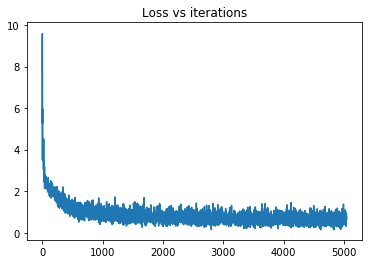

In [15]:
#Plotting loss

plt.plot(history_cb.loss)
plt.title('Loss vs iterations')
plt.show()

Normalized confusion matrix
[[ 0.78  0.02  0.01  0.04  0.    0.01  0.    0.02  0.    0.02  0.01  0.09]
 [ 0.04  0.71  0.02  0.08  0.    0.    0.    0.02  0.02  0.04  0.01  0.06]
 [ 0.03  0.01  0.78  0.02  0.    0.01  0.    0.01  0.01  0.07  0.    0.08]
 [ 0.03  0.05  0.05  0.75  0.    0.01  0.    0.01  0.01  0.02  0.    0.07]
 [ 0.02  0.    0.03  0.01  0.73  0.06  0.    0.01  0.06  0.    0.    0.07]
 [ 0.02  0.    0.    0.05  0.08  0.73  0.    0.01  0.01  0.    0.02  0.08]
 [ 0.02  0.02  0.09  0.02  0.01  0.01  0.68  0.    0.04  0.01  0.01  0.09]
 [ 0.02  0.    0.02  0.02  0.03  0.01  0.    0.77  0.05  0.01  0.    0.07]
 [ 0.02  0.    0.03  0.01  0.04  0.01  0.    0.01  0.78  0.    0.    0.09]
 [ 0.02  0.    0.05  0.03  0.    0.    0.    0.    0.    0.83  0.    0.06]
 [ 0.01  0.02  0.07  0.    0.    0.01  0.    0.    0.01  0.04  0.83  0.  ]
 [ 0.02  0.    0.    0.03  0.01  0.01  0.    0.    0.03  0.    0.    0.9 ]]


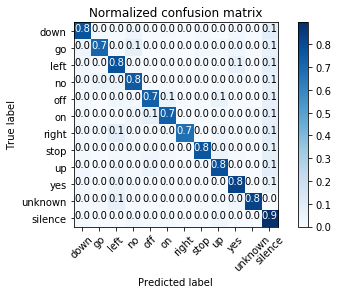

In [14]:
"""
Code from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 

"""

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
#Prediction test set 
p = model.predict(X_te)
#Converting from one hot back to integers
y_pred = [np.where(r==np.max(r))[0][0] for r in p]

#Ground truth
a = Y_te
#Converting from one hot back to integers
y_true = [np.where(r==1)[0][0] for r in a ]

#Caulculating confusion matrix 
cnf_matrix = confusion_matrix(y_true,y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['down','go','left','no','off','on','right','stop','up','yes','unknown','silence'],normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
#Label names 

labels_dict = np.load('my_way/labels_dict.npy')
print(labels_dict)

In [ ]:
#Prediction test set 
p = model.predict(X_te)
#Converting from one hot back to integers
y_pred = [np.where(r==np.max(r))[0][0] for r in p]

#Ground truth
a = Y_te
#Converting from one hot back to integers
y_true = [np.where(r==1)[0][0] for r in a ]

good = [1 for i in range(0,len(y_pred)) if y_true[i]==y_pred[i]]
accuracy = len(good)/len(y_pred)
print('Test Accuracy: ',accuracy)

#Computing confusion matrix
C = sklearn.metrics.confusion_matrix(y_true,y_pred, labels=None, sample_weight=None)
S = np.sum(np.array(C),axis=1)
C_N = C/S
print('\nNormalized confusion matrix\n')
print(np.array_str(C_N, precision=2, suppress_small=True))

In [ ]:
#Prediction training set
p = model.predict(X_tr[0:1000])
#Converting from one hot back to integers
y_pred = [np.where(r==np.max(r))[0][0] for r in p]

#Ground truth
a = Y_tr[0:1000]
#Converting from one hot back to integers
y_true = [np.where(r==1)[0][0] for r in a ]

good = [1 for i in range(0,len(y_pred)) if y_true[i]==y_pred[i]]
accuracy = len(good)/len(y_pred)
print('Train Accuracy: ',accuracy)

#Computing confusion matrix
C = sklearn.metrics.confusion_matrix(y_true,y_pred, labels=None, sample_weight=None)
S = np.sum(np.array(C),axis=1)
C_N = C/S
print('\nNormalized confusion matrix\n')
print(np.array_str(C_N, precision=2, suppress_small=True))